# Interactive Research Sketch: Entropy-Observer Duality in Galaxy Rotation Curves

This notebook explores an intuitive entropy-observer duality applied to galaxy rotation curves from the SPARC dataset. The core idea is a feedback mechanism refining entropic gravity (Verlinde-inspired) with observer-relative trades.

## Overview
- **Models**: Newtonian, Verlinde approximation, and feedback (recursive exp form for nested horizons).
- **Data**: SPARC rotmod.dat files and master table for metadata.
- **Fits**: Beta and r0 for g_fb = beta * exp(-r / r0), capturing desync/resync loops.
- **Analysis**: Chi^2 comparisons, category breakdowns, correlations (beta/r0 vs. mass/density).

Assumes SPARC data in 'data/sparc' folder. Run cells sequentially.

Author: Omer Perry (thebne@gmail.com)

Date: July 19, 2025

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import os
import pandas as pd
from ipywidgets import interact, Dropdown  # For interactive galaxy selection

## Constants and Data Loading

Define physical constants and load the SPARC master table for galaxy metadata (e.g., mass Mbar, surface brightness Sigma_e). The master table helps categorize galaxies and compute correlations.

In [28]:
# Directory containing SPARC rotmod.dat files
sparc_dir = '../galactic-spin-W1/binder/data/sparc'  # Adjust if needed

# Master table file (assume downloaded to same dir as 'SPARC_Lelli2016c.mrt')
master_file = os.path.join(sparc_dir, 'SPARC_Lelli2016c.mrt')

# Constants
G = 4.30091e-3  # G in pc Msun^{-1} (km/s)^2
kpc_to_pc = 1000
a0_m_s2 = 1.2e-10 / 6  # Adjusted a0 ~2e-11 m/s^2 for EG
pc_to_m = 3.08568e16
km_to_m = 1000
a0 = a0_m_s2 * pc_to_m / km_to_m**2  # ~0.62 (km/s)^2 / pc
Lambda = 1.1056e-52

In [29]:
# Function to load master table using fixed-width specs
def load_master_table(master_path, skiprows=98):
    if not os.path.exists(master_path):
        print(f"Master table {master_path} not found. Skipping metadata analysis.")
        return None
    # Colspecs based on byte ranges (0-based, end exclusive) from SPARC MRT format
    colspecs = [
        (0, 11),   # Galaxy A11
        (12, 14),  # T I2
        (15, 21),  # D F6.2
        (22, 27),  # e_D F5.2
        (28, 30),  # f_D I2
        (31, 35),  # Inc F4.1 (adjusted)
        (36, 40),  # e_Inc F4.1
        (41, 48),  # L[3.6] F7.3 (10^9 Lsun)
        (49, 56),  # e_L[3.6] F7.3
        (57, 62),  # Reff F5.2 (kpc)
        (63, 71),  # SBeff F8.2 (Lsun/pc^2)
        (72, 77),  # Rdisk F5.2 (kpc)
        (78, 86),  # SBdisk F8.2 (Lsun/pc^2)
        (87, 94),  # MHI F7.3 (10^9 Msun)
        (95, 100), # RHI F5.2 (kpc)
        (101, 106), # Vflat F5.1 (km/s)
        (107, 112), # e_Vflat F5.1
        (113, 116), # Q I3
        (117, 131)  # Ref A14
    ]
    names = ['Galaxy', 'T', 'D', 'e_D', 'f_D', 'Inc', 'e_Inc', 'L_3.6', 'e_L_3.6', 'Reff', 'SBeff', 'Rdisk', 'SBdisk', 'MHI', 'RHI', 'Vflat', 'e_Vflat', 'Q', 'Ref']
    
    df = pd.read_fwf(master_path, colspecs=colspecs, names=names, skiprows=skiprows)
    
    # Clean Galaxy names (strip spaces)
    df['Galaxy'] = df['Galaxy'].str.strip()
    
    # Approximate total baryonic mass Mbar ~ 0.5 * L_3.6 * 10^9 + MHI * 10^9 (M/L~0.5 for [3.6] band in SPARC)
    df['Mbar'] = 0.5 * df['L_3.6'] * 1e9 + df['MHI'] * 1e9
    
    # Set index
    df.set_index('Galaxy', inplace=True)
    return df

# Load master if available
master_df = load_master_table(master_file)

## Galaxy Processing Function

This function processes a single galaxy's rotation curve data: loads the file, computes models (Newtonian, Verlinde, feedback with recursive exp form), fits parameters, and returns metrics.

In [30]:
# Function to load and process a single file
def process_galaxy(file_path, feedback_form='exp'):  # 'exp' for recursive
    data = np.loadtxt(file_path)
    r_kpc = data[:, 0]  # Radius in kpc
    v_obs = data[:, 1]  # Observed velocity in km/s
    e_v = data[:, 2]  # Error (assume >0; if zero, add small epsilon)
    e_v = np.maximum(e_v, 1e-3)  # Avoid division by zero
    v_gas = data[:, 3]
    v_disk = data[:, 4]
    v_bul = data[:, 5]

    # Baryonic velocity
    v_bar = np.sqrt(v_gas**2 + v_disk**2 + v_bul**2)

    # Radius in pc
    r_pc = r_kpc * kpc_to_pc

    # Enclosed mass M_bar(r) in Msun
    M_bar = (r_pc * v_bar**2) / G

    # Mean r for normalization in exp form
    r_mean = np.mean(r_pc) if len(r_pc) > 0 else 1.0

    # Model function: v = sqrt(r * g_obs), g_obs = g_bar + sqrt(g_bar * a0) + g_fb
    def v_model(r_kpc, beta, r0=r_mean):  # Fit beta and r0 for recursion
        r = r_kpc * kpc_to_pc
        g_bar = G * M_bar / r**2
        g_ent = np.sqrt(g_bar * a0)
        if feedback_form == '1/r':
            g_fb = beta / r  # Original
        else:  # 'exp' for recursive decay
            g_fb = Lambda + beta * np.exp(-r / r0 - Lambda)  # Decay across nested scales
        g_obs = g_bar + g_ent + g_fb
        return np.sqrt(r * g_obs)

    # Fit (two params: beta, r0)
    try:
        popt, _ = curve_fit(v_model, r_kpc, v_obs, sigma=e_v, p0=[0.1, r_mean], bounds=([-np.inf, 0.1], [np.inf, np.max(r_pc)*2]))
        beta_fit, r0_fit = popt
    except:
        raise
        beta_fit, r0_fit = 0.0, r_mean  # Fallback

    # Predicted with feedback
    v_pred_fb = v_model(r_kpc, beta_fit, r0_fit)

    # Pure entropic (beta=0)
    v_pred_ver = v_model(r_kpc, 0, r0_fit)

    # Pure Newtonian (only g_bar)
    g_bar = G * M_bar / r_pc**2
    v_pred_newt = np.sqrt(r_pc * g_bar)

    # Chi^2 for Newtonian
    chi2_newt = np.sum(((v_obs - v_pred_newt) / e_v)**2)
    dof = len(r_kpc) - 1  # For reduced, but we compare raw chi2
    reduced_chi2_newt = chi2_newt / dof if dof > 0 else np.inf

    # Chi^2 for Verlinde (pure entropic)
    chi2_ver = np.sum(((v_obs - v_pred_ver) / e_v)**2)
    reduced_chi2_ver = chi2_ver / dof if dof > 0 else np.inf

    # Chi^2 for feedback
    chi2_fb = np.sum(((v_obs - v_pred_fb) / e_v)**2)
    reduced_chi2_fb = chi2_fb / (dof - 2) if dof > 2 else np.inf  # Adjust dof for 2 params

    galaxy_name = os.path.basename(file_path).replace('_rotmod.dat', '')

    # Metadata from master if available
    category = 'Unknown'
    mbar = np.nan
    sigma_e = np.nan
    if master_df is not None and galaxy_name in master_df.index:
        row = master_df.loc[galaxy_name]
        mbar = row['Mbar']
        sigma_e = row['SBeff']  # Effective surface brightness as Sigma_e proxy
        # Categorize: LSB if SBeff < 100 Lsun/pc^2, HSB >1000, else intermediate
        if sigma_e < 100:
            category = 'LSB/Ultra-Diffuse Dwarf'
        elif sigma_e > 1000:
            category = 'Massive/High-SB Spiral'
        else:
            category = 'Intermediate Dwarf/Spiral'

    return {
        'galaxy': galaxy_name,
        'chi2_newt': chi2_newt,
        'reduced_chi2_newt': reduced_chi2_newt,
        'chi2_ver': chi2_ver,
        'reduced_chi2_ver': reduced_chi2_ver,
        'chi2_fb': chi2_fb,
        'reduced_chi2_fb': reduced_chi2_fb,
        'beta': beta_fit,
        'r0': r0_fit,  # New: recursive scale
        'improvement_ver': (chi2_ver - chi2_fb) / chi2_ver * 100 if chi2_ver > 0 else 0,
        'improvement_newt': (chi2_newt - chi2_fb) / chi2_newt * 100 if chi2_newt > 0 else 0,
        'category': category,
        'mbar': mbar,
        'sigma_e': sigma_e
    }


## Processing All Galaxies

Find and process all rotmod.dat files in the directory, using the recursive exponential feedback form. This cell runs the fits and prints per-galaxy results.

In [31]:
# Find all rotmod.dat files
rotmod_files = [os.path.join(sparc_dir, f) for f in os.listdir(sparc_dir) if f.endswith('_rotmod.dat')]

# Process all with exp form for recursion
results = []
for file in rotmod_files:
    try:
        res = process_galaxy(file, feedback_form='exp')
        results.append(res)
        print(f"Processed {res['galaxy']}: Newtonian reduced chi^2={res['reduced_chi2_newt']:.2f}, Verlinde={res['reduced_chi2_ver']:.2f}, Feedback={res['reduced_chi2_fb']:.2f}, Beta={res['beta']:.2e}, r0={res['r0']:.2e}, Imp Ver={res['improvement_ver']:.1f}%, Imp Newt={res['improvement_newt']:.1f}%, Category={res['category']}, Mbar={res['mbar']:.2e}, Sigma_e={res['sigma_e']:.2f}")
    except Exception as e:
        print(f"Error processing {file}: {e}")

C:\Users\Omer\AppData\Local\Temp\ipykernel_31492\2019791162.py:34: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(r * g_obs)


Error processing ../galactic-spin-W1/binder/data/sparc\CamB_rotmod.dat: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Processed D512-2: Newtonian reduced chi^2=14.81, Verlinde=0.40, Feedback=0.20, Beta=-1.33e-01, r0=2.38e+03, Imp Ver=83.6%, Imp Newt=99.6%, Category=LSB/Ultra-Diffuse Dwarf, Mbar=2.44e+08, Sigma_e=9.22
Processed D564-8: Newtonian reduced chi^2=34.22, Verlinde=3.88, Feedback=0.47, Beta=-4.89e-01, r0=6.52e+02, Imp Ver=92.7%, Imp Newt=99.2%, Category=LSB/Ultra-Diffuse Dwarf, Mbar=4.55e+07, Sigma_e=10.11
Processed D631-7: Newtonian reduced chi^2=93.87, Verlinde=20.92, Feedback=22.42, Beta=8.30e-02, r0=1.44e+04, Imp Ver=7.1%, Imp Newt=79.3%, Category=LSB/Ultra-Diffuse Dwarf, Mbar=3.88e+08, Sigma_e=20.93
Processed DDO064: Newtonian reduced chi^2=9.02, Verlinde=0.71, Feedback=0.48, Beta=1.70e-01, r0=5.96e+03, Imp Ver=42.3%, Imp Newt=95.5%, Category=LSB/Ultra-Diffuse Dwarf, Mbar=2.90e+08, Sigma_e=17.41
Processed DDO154: Newtonian reduced c

## Summary Statistics

Compute average chi^2, improvements, and category breakdowns. This quantifies how the recursive feedback outperforms baselines.

In [32]:
# Summary
if results:
    avg_chi2_newt = np.mean([r['reduced_chi2_newt'] for r in results if np.isfinite(r['reduced_chi2_newt'])])
    avg_chi2_ver = np.mean([r['reduced_chi2_ver'] for r in results if np.isfinite(r['reduced_chi2_ver'])])
    avg_chi2_fb = np.mean([r['reduced_chi2_fb'] for r in results if np.isfinite(r['reduced_chi2_fb'])])
    avg_r0 = np.mean([r['r0'] for r in results if np.isfinite(r['r0'])])
    num_better_ver = sum(1 for r in results if r['chi2_fb'] < r['chi2_ver'])
    pct_better_ver = (num_better_ver / len(results)) * 100
    num_better_newt = sum(1 for r in results if r['chi2_fb'] < r['chi2_newt'])
    pct_better_newt = (num_better_newt / len(results)) * 100
    print("\nFinal Summary:")
    print(f"Average reduced chi^2 Newtonian: {avg_chi2_newt:.2f}")
    print(f"Average reduced chi^2 Verlinde: {avg_chi2_ver:.2f}")
    print(f"Average reduced chi^2 Feedback: {avg_chi2_fb:.2f}")
    print(f"Average r0 (recursive scale): {avg_r0:.2e}")
    print(f"Feedback better than Verlinde in {num_better_ver}/{len(results)} galaxies ({pct_better_ver:.1f}%)")
    print(f"Feedback better than Newtonian in {num_better_newt}/{len(results)} galaxies ({pct_better_newt:.1f}%)")

    # Category averages if master loaded
    if master_df is not None:
        categories = ['LSB/Ultra-Diffuse Dwarf', 'Intermediate Dwarf/Spiral', 'Massive/High-SB Spiral']
        for cat in categories:
            cat_results = [r for r in results if r['category'] == cat]
            if cat_results:
                avg_chi2_newt_cat = np.mean([r['reduced_chi2_newt'] for r in cat_results if np.isfinite(r['reduced_chi2_newt'])])
                avg_chi2_ver_cat = np.mean([r['reduced_chi2_ver'] for r in cat_results if np.isfinite(r['reduced_chi2_ver'])])
                avg_chi2_fb_cat = np.mean([r['reduced_chi2_fb'] for r in cat_results if np.isfinite(r['reduced_chi2_fb'])])
                avg_improv_ver = np.mean([r['improvement_ver'] for r in cat_results])
                avg_beta = np.mean([r['beta'] for r in cat_results])
                avg_r0_cat = np.mean([r['r0'] for r in cat_results])
                num_cat = len(cat_results)
                print(f"\nCategory: {cat} ({num_cat} galaxies)")
                print(f"Avg reduced chi^2 Newtonian: {avg_chi2_newt_cat:.2f}")
                print(f"Avg reduced chi^2 Verlinde: {avg_chi2_ver_cat:.2f}")
                print(f"Avg reduced chi^2 Feedback: {avg_chi2_fb_cat:.2f}")
                print(f"Avg Improvement Verlinde: {avg_improv_ver:.1f}%")
                print(f"Avg Beta: {avg_beta:.2e}")
                print(f"Avg r0: {avg_r0_cat:.2e}")

    # Correlations if master loaded
    if master_df is not None:
        betas = [r['beta'] for r in results if np.isfinite(r['mbar'])]
        log_mbars = [np.log10(r['mbar']) for r in results if np.isfinite(r['mbar'])]
        sigmas = [r['sigma_e'] for r in results if np.isfinite(r['sigma_e'])]
        r0s = [r['r0'] for r in results if np.isfinite(r['r0'])]
        if len(betas) > 1 and len(log_mbars) > 1:
            corr_beta_mbar, _ = pearsonr(betas, log_mbars)
            corr_beta_sigma, _ = pearsonr(betas, sigmas)
            corr_r0_mbar, _ = pearsonr(r0s, log_mbars)
            corr_r0_sigma, _ = pearsonr(r0s, sigmas)
            print("\nCorrelations:")
            print(f"Beta vs log(Mbar): Pearson r = {corr_beta_mbar:.3f}")
            print(f"Beta vs Sigma_e: Pearson r = {corr_beta_sigma:.3f}")
            print(f"r0 vs log(Mbar): Pearson r = {corr_r0_mbar:.3f}")
            print(f"r0 vs Sigma_e: Pearson r = {corr_r0_sigma:.3f}")
else:
    print("No valid rotmod files found.")


Final Summary:
Average reduced chi^2 Newtonian: 278.70
Average reduced chi^2 Verlinde: 120.71
Average reduced chi^2 Feedback: 7.52
Average r0 (recursive scale): 1.27e+04
Feedback better than Verlinde in 163/163 galaxies (100.0%)
Feedback better than Newtonian in 162/163 galaxies (99.4%)

Category: LSB/Ultra-Diffuse Dwarf (86 galaxies)
Avg reduced chi^2 Newtonian: 309.32
Avg reduced chi^2 Verlinde: 46.57
Avg reduced chi^2 Feedback: 3.55
Avg Improvement Verlinde: 76.7%
Avg Beta: 7.20e-02
Avg r0: 1.00e+04

Category: Intermediate Dwarf/Spiral (55 galaxies)
Avg reduced chi^2 Newtonian: 201.76
Avg reduced chi^2 Verlinde: 94.72
Avg reduced chi^2 Feedback: 9.60
Avg Improvement Verlinde: 84.6%
Avg Beta: -7.25e+00
Avg r0: 1.69e+04

Category: Massive/High-SB Spiral (22 galaxies)
Avg reduced chi^2 Newtonian: 351.35
Avg reduced chi^2 Verlinde: 475.53
Avg reduced chi^2 Feedback: 17.85
Avg Improvement Verlinde: 84.8%
Avg Beta: -3.27e+01
Avg r0: 1.25e+04

Correlations:
Beta vs log(Mbar): Pearson r = 

## Interactive Galaxy Plot

Select a galaxy from the dropdown to plot its rotation curve with models. This visualizes how the recursive feedback fits the data.

In [33]:
# Function to plot a single galaxy (for interactivity)
def plot_galaxy(galaxy_name):
    res = next((r for r in results if r['galaxy'] == galaxy_name), None)
    if res is None:
        print(f"Galaxy {galaxy_name} not found.")
        return
    
    # Reload data for plot
    file_path = os.path.join(sparc_dir, f"{galaxy_name}_rotmod.dat")
    data = np.loadtxt(file_path)
    r_kpc = data[:, 0]
    v_obs = data[:, 1]
    e_v = data[:, 2]
    
    # Compute models
    r_pc = r_kpc * kpc_to_pc
    v_gas = data[:, 3]
    v_disk = data[:, 4]
    v_bul = data[:, 5]
    v_bar = np.sqrt(v_gas**2 + v_disk**2 + v_bul**2)
    M_bar = (r_pc * v_bar**2) / G
    g_bar = G * M_bar / r_pc**2
    v_pred_newt = np.sqrt(r_pc * g_bar)
    g_ent = np.sqrt(g_bar * a0)
    v_pred_ver = np.sqrt(r_pc * (g_bar + g_ent))
    g_fb = res['beta'] * np.exp(-r_pc / res['r0'])
    v_pred_fb = np.sqrt(r_pc * (g_bar + g_ent + g_fb))
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(r_kpc, v_obs, yerr=e_v, fmt='o', label='Observed')
    plt.plot(r_kpc, v_pred_newt, '-.', label='Newtonian')
    plt.plot(r_kpc, v_pred_ver, '--', label='Pure Entropic (Verlinde approx)')
    plt.plot(r_kpc, v_pred_fb, '-', label='With Recursive Feedback')
    plt.xlabel('Radius (kpc)')
    plt.ylabel('Velocity (km/s)')
    plt.legend()
    plt.title(f"{galaxy_name} Rotation Curve (chi^2 FB: {res['reduced_chi2_fb']:.2f}, beta: {res['beta']:.2e}, r0: {res['r0']:.2e})")
    plt.show()

# Interactive dropdown
galaxies = [r['galaxy'] for r in results]
interact(plot_galaxy, galaxy_name=Dropdown(options=galaxies, description='Galaxy:'));

interactive(children=(Dropdown(description='Galaxy:', options=('D512-2', 'D564-8', 'D631-7', 'DDO064', 'DDO154…

## Correlation Plots

Visualize correlations for beta and r0 vs. log(Mbar) and Sigma_e. These help see if feedback parameters scale with galaxy properties.

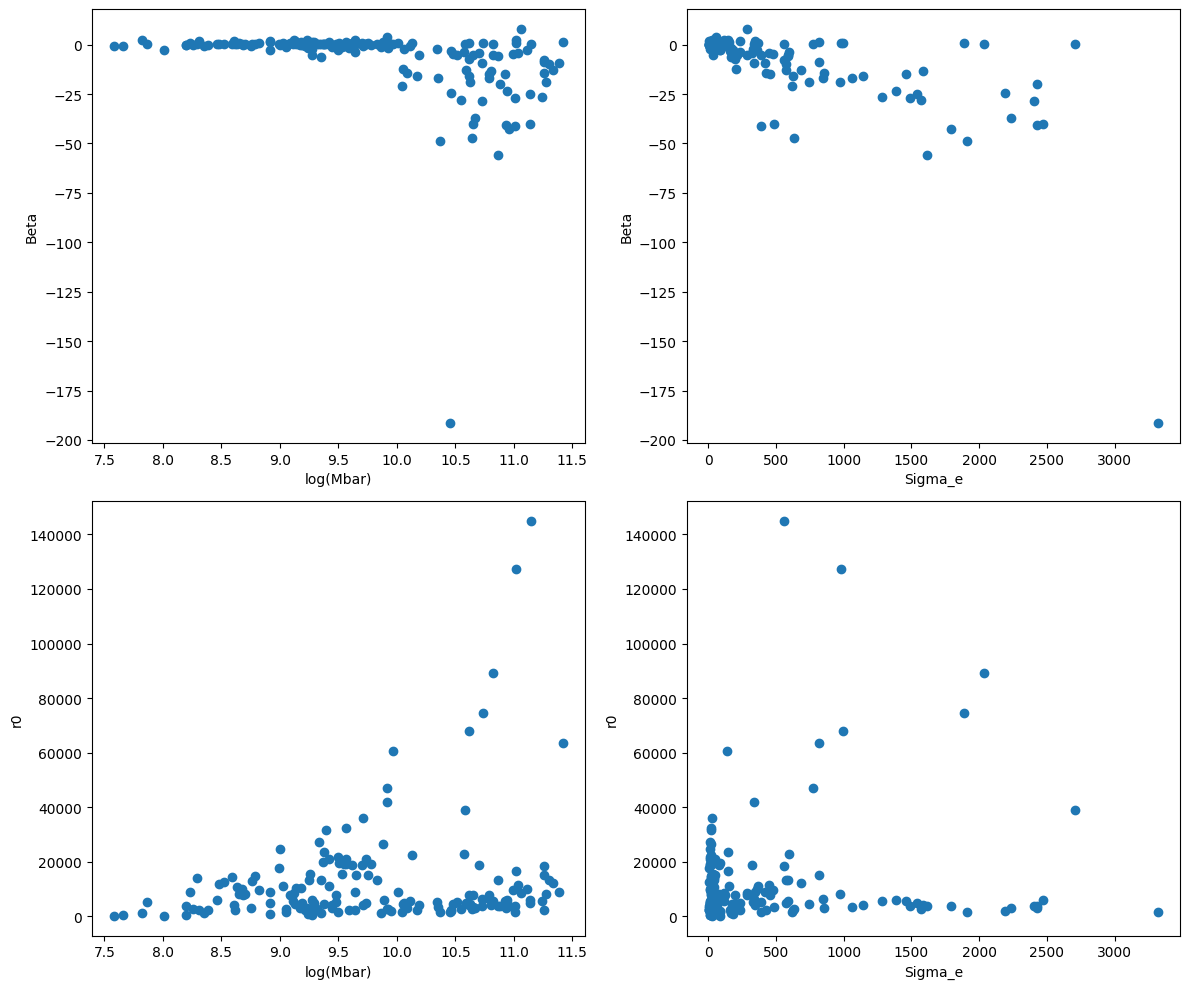

In [34]:
if master_df is not None:
    log_mbars = [np.log10(r['mbar']) for r in results if np.isfinite(r['mbar'])]
    sigmas = [r['sigma_e'] for r in results if np.isfinite(r['sigma_e'])]
    betas = [r['beta'] for r in results if np.isfinite(r['mbar'])]
    r0s = [r['r0'] for r in results if np.isfinite(r['mbar'])]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0,0].scatter(log_mbars, betas)
    axs[0,0].set_xlabel('log(Mbar)')
    axs[0,0].set_ylabel('Beta')
    axs[0,1].scatter(sigmas, betas)
    axs[0,1].set_xlabel('Sigma_e')
    axs[0,1].set_ylabel('Beta')
    axs[1,0].scatter(log_mbars, r0s)
    axs[1,0].set_xlabel('log(Mbar)')
    axs[1,0].set_ylabel('r0')
    axs[1,1].scatter(sigmas, r0s)
    axs[1,1].set_xlabel('Sigma_e')
    axs[1,1].set_ylabel('r0')
    plt.tight_layout()
    plt.show()

## Improvement Histograms

Histograms of improvement percentages vs. Verlinde and Newtonian, to see distribution of gains.

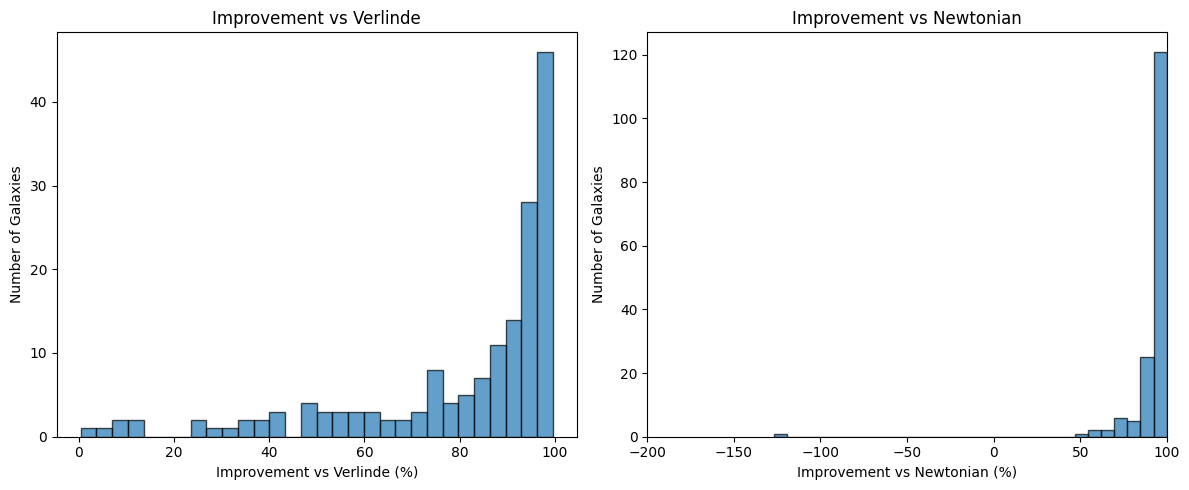

In [35]:
imp_ver = [r['improvement_ver'] for r in results]
imp_newt = [r['improvement_newt'] for r in results]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: Improvement vs Verlinde
axs[0].hist(imp_ver, bins=30, edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Improvement vs Verlinde (%)')
axs[0].set_ylabel('Number of Galaxies')
axs[0].set_title('Improvement vs Verlinde')

# Right plot: Improvement vs Newtonian with clipped range
# Set a reasonable display range
display_min, display_max = -200, 100

# Filter data for display
imp_newt_clipped = [x for x in imp_newt if display_min <= x <= display_max]
below_range = sum(1 for x in imp_newt if x < display_min)
above_range = sum(1 for x in imp_newt if x > display_max)

# Create histogram with clipped data
axs[1].hist(imp_newt_clipped, bins=30, edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Improvement vs Newtonian (%)')
axs[1].set_ylabel('Number of Galaxies')
axs[1].set_title('Improvement vs Newtonian')
axs[1].set_xlim(display_min, display_max)

# Add text about outliers
outlier_text = []
if below_range > 0:
    outlier_text.append(f'{below_range}/{len(results)} values < {display_min}%')
if above_range > 0:
    outlier_text.append(f'{above_range}/{len(results)} values > {display_max}%')
if outlier_text:
    axs[1].text(0.02, 0.98, '\n'.join(outlier_text), 
                transform=axs[1].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()